# Milestone 1 

To create a recommender system you need to understand the data you are going to feed it. 

In the following the milestone 1 questions will be answered:

1. How old are the data (number of datapoints pr year)
2. How many users and movies are mentioned in the dataset?
3. How popular are popular movies?
4. How many long-tail movies are there?
5. How many movies has each user rated?
6. If you had a recommender system that only recommends the most popular movies, how good would it be? 


Below you will find my solution to the task described. Each of the questions above can be answered in different ways, so if your solution doesnt look like mine, then dont worry. 

First some imports and retrieving the data. 

## imports

In [220]:
import numpy as np
import pandas as pd
import seaborn as sb
import requests
import io

### Load data

In [221]:
url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat"
columns = ["user_id","movie_id","rating","rating_timestamp"]

textStream = requests.get(url).content
df=pd.read_csv(io.StringIO(textStream.decode('utf-8')), sep="::", names=columns)

/Users/kifal2/.local/share/virtualenvs/live-project-FVUeIAog/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


### Overview of the data

When getting your hands on new data its always a good idea to have a look at a few rows (the head of the dataframe) and count how many there is of each. 

In [222]:
df.head()

,user_id,movie_id,rating,rating_timestamp
0,1,114508,8,1381006850
1,2,208092,5,1586466072
2,2,358273,9,1579057827
3,2,10039344,5,1578603053
4,2,6751668,9,1578955697


In [223]:
df.nunique()

user_id              67271
movie_id             35442
rating                  11
rating_timestamp    850084
dtype: int64

It is often good to divide data into buckets, and look at how things develop. We will therefore add a year column to the table. (I might be even better to do it pr month.)

In [224]:
df['datetime'] = df['rating_timestamp'].apply(lambda ts: pd.to_datetime(ts, unit='s'))
df['year'] = df['datetime'].apply(lambda dt: dt.year)

### 1) How old are the data (number of datapoints pr year)

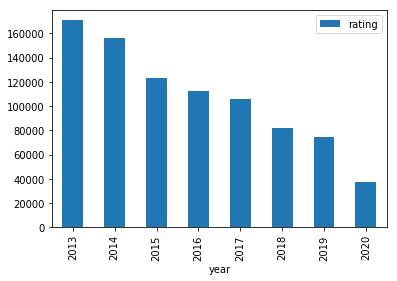

In [225]:
df[['year', 'rating']].groupby('year').count().plot.bar()

The number of ratings have fallen over the years. So far only around 30000 ratings has then cast in 2020. This means that new films will have a relative little ratings giving to them. That is of course But it also seems that 2020 will see an increase as it is close to having half as many as 2019 but its only four months into 2020. 

## 2) How many users and movies are mentioned in the dataset?

This question is already answered above, but here they are again. To understand better the number of users, I group first the users then the movie in years to understand how the data is distributed over the years.

In [226]:
print(f"The dataset contains {df['user_id'].nunique()} users")
print(f"The dataset contains {df['movie_id'].nunique()} movies")

The dataset contains 67271 users
The dataset contains 35442 movies


#### Number of users pr year

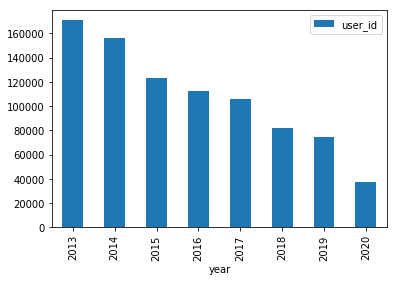

In [219]:
df[["user_id", "year"]].groupby(["year"]).count().plot.bar()

Sadly it turns out that over the years the amount of users has been decreesing 

#### Number of movies pr year:

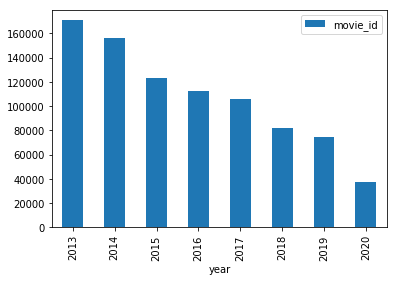

In [216]:
df[["movie_id", "year"]].groupby(["year"]).count().plot.bar()

Also number of movies is decreasing. 

## 3) How popular are popular movies?

Most people like popular movies, if the didn't then they wouldn't be popular. In the following we will look at which movies are popular. 

In [70]:
popularity = df[['movie_id', 'user_id']].groupby('movie_id').count().sort_values(by='user_id', ascending=False).reset_index()
popularity.head()

,movie_id,user_id
0,1454468,3086
1,816692,2869
2,993846,2793
3,8579674,2773
4,7286456,2680


The popular ones has a lot of ratings, but popularity is relative, and should be viewed compared to how many ratings a movie as on average.

/Users/kifal2/.local/share/virtualenvs/live-project-FVUeIAog/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


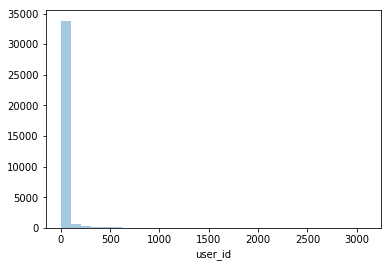

In [71]:
sb.distplot(popularity['user_id'],kde = False, bins= 30)

What's the distribution of ratings?

In [72]:
popularity['user_id'].describe()

count    35414.000000
mean        24.352177
std        113.551324
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3086.000000
Name: user_id, dtype: float64

The 75% of movies has seven or less ratings. Then having more than a 1000 is quite impressive

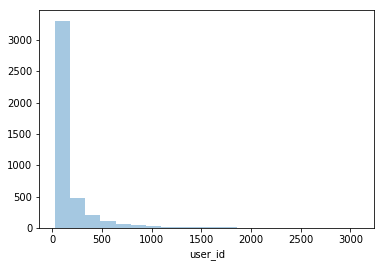

In [73]:
sb.distplot(popularity[popularity['user_id']>25]['user_id'],kde = False, bins= 20)

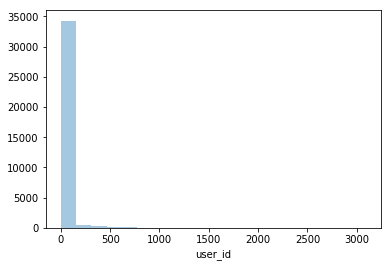

In [74]:
popularity[popularity['user_id'] > 500].count()

sb.distplot(popularity['user_id'],kde = False, bins= 20)

The film with most ratings has id: 1454468, which has been rated 3081 times. This tells us that users has reacted to this film a lot of times, but as such it doesnt say if it is a popular movie, most ratings could be low. However as the following plot will show you it is mostly good ratings that is giving.

The next thing you should consider when looking at popularity, is how old the ratings are. What if all the good ratings were giving in 2013 and only bad ones were giving in 2020 (which is not the case as you can see below also).

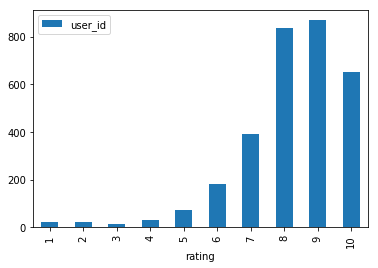

In [75]:
df[df['movie_id']== 1454468][['rating', 'user_id']].groupby('rating').count().plot.bar()

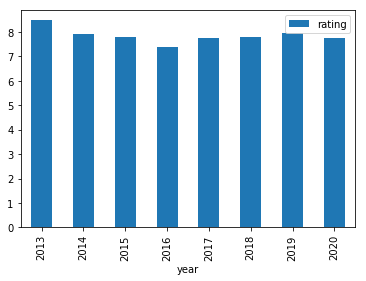

In [76]:
df[df['movie_id']== 1454468][['year', 'rating']].groupby('year').mean().plot.bar()

### 3) How many long-tail movies are there?

To answer this, one first needs to define what is the long-tail. One way we could do it is simply to simply say that it is the un-popular half of the movies. But mostly it is movies which are not interacted with more than ones or twice a year, depending on how often content is usually consumed.


First we will calculate how many ratings each movie has. Then we will group each of those counts to understand how many movies only have one rating, two ratings ect. Remember that there were 35414 movie_ids (at the time of writing this) that means that if we should take the unpopular half of the movie_ids as the long tail we need only to look at (35414/2) 17707 movies. 


In [146]:
#first calculate how many ratings each movie has. 
def calculate_user_movie_counts(df):
    user_movie_counts = df[['user_id', 'movie_id']].groupby(['movie_id']).count().reset_index().rename({'user_id':'user_count'})
    user_movie_counts = user_movie_counts.rename(columns={"user_id":"user_count"})
    return user_movie_counts.sort_values(by="user_count", ascending=False)
user_movie_counts = calculate_user_movie_counts(df)
user_movie_counts.head()

,movie_id,user_count
18621,1454468,3086
15534,816692,2869
16240,993846,2793
34571,8579674,2773
33645,7286456,2680


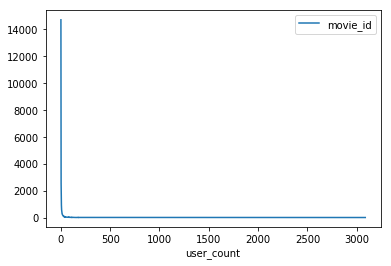

In [147]:
# now calculate how many movies only had one rating, two ratings ect. 
movie_ratings_counts_counts = user_movie_counts.groupby("user_count").count()
movie_ratings_counts_counts.plot()

In [145]:
movie_ratings_counts_counts.head()

,movie_id
user_count,
1,14694
2,4915
3,2529
4,1755
5,1163


If you look at the data above you will see that more than half of all movies have less than or equal to two ratings, so in our case.

It worth mentioning that new films has a bigger chance at being put in the long-tail simply because they have been around shorter time, and therefore less time for people to rate them.

Another thing to consider here is that many of the movies that were popular a few years ago are not any longer. So it would be more realistic only looking at recent data and then create a long-tail from that. 

Lets redo the plot and counts from above with 2019 and 2020 data.

In [149]:
user_movie_counts_only_new_data = calculate_user_movie_counts(df[df['year'] > 2018])
user_movie_counts_only_new_data.head()

,movie_id,user_count
9993,8579674,2773
9352,7286456,2680
9022,6751668,1711
9262,7131622,1538
7437,4154796,1404


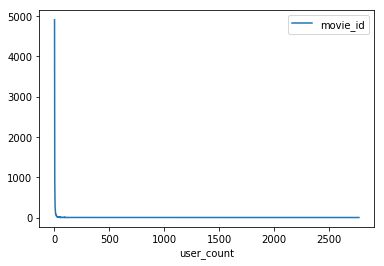

In [154]:
movie_ratings_counts_counts = user_movie_counts_only_new_data.groupby("user_count").count()
movie_ratings_counts_counts.plot()

Looking only at 2019-2020 data narrows the amount of movies a bit. Lets calculate how many we have:

In [158]:
print(f"Number of movies in recent data: {movie_ratings_counts_counts.sum()}")
print(f"Half number of movies in recent data: {movie_ratings_counts_counts.sum()/2}")

number of movies in recent data: movie_id    10794
dtype: int64
half number of movies in recent data: movie_id    5397.0
dtype: float64


In [160]:
movie_ratings_counts_counts.head()

,movie_id
user_count,
1,4908
2,1831
3,897
4,587
5,381


The pattern repeats, it is still movies with one or two ratings in the long tail. 

### 4) How many movies has each user rated?

Todo:
* Count how many users have rated only one film, two films and so on. 

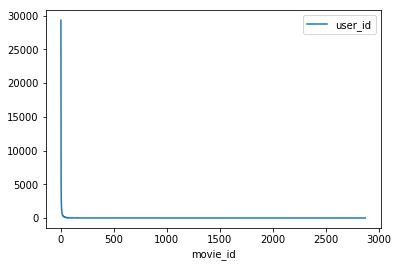

In [167]:
df[['user_id','movie_id']].groupby('user_id').count().reset_index().groupby('movie_id').count().plot()

Sadly most people has only rated one or two movies. Data with users who had only consumed/rated one product makes it hard to do recommender systems. But more on that later. 

### 5) If you had a recommender system that only recommends the most popular movies, how good would it be?

In the following I will first find the 10 most popular movies in 2020.

Then I will see how many users rated these movies in 2020. When building a recommender system, you will divide data into a training dataset and a test dataset. For example we could say that all data from 2020 will be the data and the rest is training data. 

When splitting the data like this, a recommender system will be tested by seeing how good it is at predicting the test data. 


Todo:
* Find the most rated movies in 2020.
* Find for each user their top rated movies.
* calculate how many would be happy with the top 10. 

In [184]:
popularity = df[['movie_id', 'user_id']].groupby('movie_id').count().sort_values(by='user_id', ascending=False).reset_index()
top_movies = popularity.nlargest(10, 'user_id')['movie_id'].values


In [185]:
top_movies

array([1454468,  816692,  993846, 8579674, 7286456,  770828,  816711,
       1300854, 1670345, 2267998])

In [186]:
thisyear = df[df['year'] > 2019]

In [188]:
thisyear.nunique()

user_id              9097
movie_id             4913
rating                 11
rating_timestamp    27073
datetime            27073
year                    1
dtype: int64

In [191]:
user_movies = thisyear[['user_id', 'movie_id']].groupby('user_id')['movie_id'].apply(list).reset_index(name='movies')


In [192]:
user_movies.head()

,user_id,movies
0,2,"[208092, 358273, 10039344, 6751668, 7131622, 7..."
1,11,[8579674]
2,12,[3226786]
3,13,"[1478839, 7343762, 8367814, 8579674]"
4,34,[10367276]


In [194]:
user_movies["top_movies"] = user_movies['movies'].apply(lambda m: set(m).intersection(top_movies))

In [208]:
user_movies["likes_top_movies"] = user_movies['top_movies'].apply(lambda m: len(m) > 0)
user_movies = user_movies.reset_index()

In [211]:
user_movies[['user_id', 'likes_top_movies']].groupby('likes_top_movies').count()

,user_id
likes_top_movies,
False,5979
True,3118


So if we do a recommender system that always shows the top 10 movies then we would give good recommendations to 3118 users. This is what your recommender algorithm should beat (the one you should build in a later milestone). Of course it should be a lot better. But this is a good low benchmark to start out with.

This result should not be considered too important, because all movies rated by a user was included, even if the user rated them low. This means that the number is overly positive. On the other hand since users have rated them, then they must have watched them.